# Classifying existence of Quasar using Quantum Machine Learning



The accuracy of the model is $94\%$ via a quantum machine learning model from NASA image. The image is further divided into a small $16 \times 16$ image as input data. 

-----

Then the data is encoded and trained using a quantum circuit using the parameterized quantum circuit taken from the paper [Expressibilitty and entangling capability of parameterized quantum circuit for hybrid quantum-classical algorithms](https://arxiv.org/abs/1905.10876).

-----

With the high expressibility of the circuit, the model is trained and tested with Cross-Entropy as the Loss function and **L-BFGS** algorithm for optimization.

Dataset is taken from The Sloan Digital Sky Survey Quasar Catalog: sixteenth data release (DR16Q)


This algorithm is realized in **PyTorch** and **Qiskit** machine learning module.

## Pre-Processing of Image


Import necessary Libraries for Image pre-processing

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

-----
-----

Import Basic python packages and the two python helper scirpts that we made to make our life easier.



In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('PyFiles')   # where the Helper files are saved
# Pull in the helper files.
from ImageRead import *  # the helper files we created to read Images
from QNN import *        # the helper file that creates the QNN


In [3]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

## Loading the dataset

Load all the data files from the respective data folder and use the helper function to divide the images into smaller parts to make it easier for the QNN to read and make sense of.

In [4]:
from ImageRead import callImage, imageResize, imageBinarize  


pathY=r'dataset/qso/'
pathN=r'dataset/no_qso/'
nameN=''
nameY=''

inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

Randomize and Re-Shuffle the data set to make it better to train.

In [5]:
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()


np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

## Visualize

Display the images from the folder after all the pre-processing and ready to be feeded to the QNN.

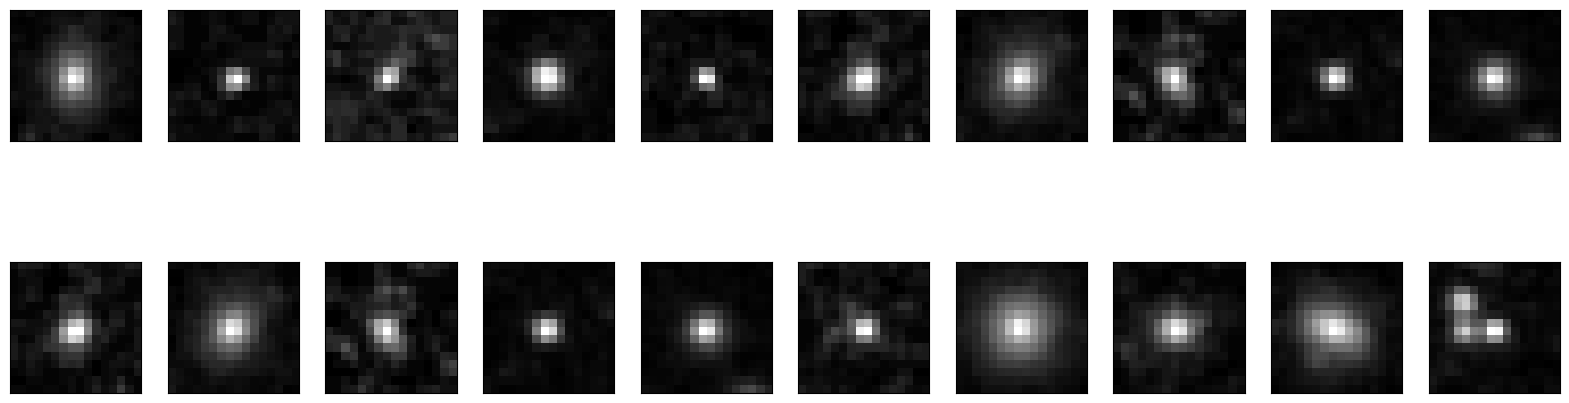

In [6]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(n_samples_show):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    


## The Quantum Neural Network


Import necessary files for the training.

In [7]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit.parameter import Parameter
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam
from PyFiles.QNN import circuit15, encoding, parity
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler


sampler = Sampler()



# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=256
qc = QuantumCircuit(nqubits)

# Encoding
param_x=[];
for i in range(num_inputs):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)


feature_map = encoding(qc,param_x,22)


# Optimzing circuit PQC
param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qc,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

# qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
#                   interpret=parity, output_shape=2, quantum_instance=qi)
qnn2 = SamplerQNN(circuit= qc,  input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, sampler= sampler)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


C:\Users\Ansari\AppData\Local\Temp\ipykernel_16016\1710213626.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


# Learning Rate 0.05

Training the model with a Learning Rate of 0.05

In [8]:
# define optimizer and loss function

from PyFiles.QNN import normlaizeData


model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [9]:
from torch import Tensor
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.48


This accuracy without applying any optimizer and just running on the first instance, as expected that the model is correct half of the time, even if you randomly classify the images you'll get the accuracy near $50\%$ , so that's what we see here.

In [10]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [11]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure) 
optimizer.step(closure)

34.83810043334961
34.80035400390625
34.7272834777832
34.635536193847656
34.53863525390625
34.44520950317383
34.35776901245117
34.27717208862305
34.20449447631836
34.14042663574219


In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


Here you can see that the accuracy goes to $92\%$ , which says that our model is good at classifying.

# Learning rate 0.06

Increasing the Learning Rate with $+0.01$ to $0.06$, we'll see how it affects the accuracy.

In [ ]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.06)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [ ]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.092506408691406
32.27847671508789
31.932584762573242
31.801755905151367
31.696422576904297
31.596323013305664
31.49781036376953
31.399715423583984
31.304540634155273
31.219013214111328
31.14921760559082
31.095157623291016
31.052919387817383
31.01851463317871
30.989017486572266
30.96230697631836
30.936681747436523
30.910457611083984
30.88165283203125
30.847291946411133
30.801864624023438
30.7325382232666
30.610553741455078
30.497982025146484
30.462387084960938
30.439420700073242
30.41527557373047
30.38955307006836
30.363304138183594
30.336950302124023
30.31045150756836
30.28369903564453
30.256694793701172
30.22960662841797
30.202392578125
30.172588348388672
30.144634246826172
30.120256423950195
30.096738815307617


tensor(30.8473, grad_fn=<AddBackward0>)

In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


We see the accuracy drops to $92\%$ from $94\%$.

# Learning Rate 0.07

Increasing the accuracy even further by $0.01$

In [ ]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.07)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [ ]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.07685089111328
32.15932846069336
31.843116760253906
31.71990394592285
31.616920471191406
31.518083572387695
31.42047691345215
31.324111938476562
31.233501434326172
31.156253814697266
31.095962524414062
31.04983901977539
31.013206481933594
30.98231315612793
30.954456329345703
30.927480697631836
30.899188995361328
30.866764068603516
30.82535743713379
30.764251708984375
30.654775619506836
30.505294799804688
30.467437744140625
30.445926666259766
30.420310974121094
30.390424728393555
30.358802795410156
30.326568603515625
30.2938232421875
30.260597229003906
30.227100372314453
30.19232749938965
30.15595245361328
30.12395477294922
30.094696044921875
30.066675186157227
30.039791107177734
30.01435661315918
29.9906005859375


tensor(30.7643, grad_fn=<AddBackward0>)

In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


The acciracy remained constant at $92\%$

# Test Model

Testing the model with unseen data.

In [32]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

pathY=r'dataset/qso1/'
pathN=r'dataset/noqso1/'
nameN=''
nameY=''
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

Xtest= [normlaizeData(dataInput[i].flatten()) for i in range(25)]
y01test= [data_target_o[i] for i in range(25)]

Xtest1= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01test1= [data_target_o[i] for i in range(50)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy25data:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

y_predict1 = []
for x in Xtest1:
    output = model2(Tensor(x))
    y_predict1 += [np.argmax(output.detach().numpy())]

print('Accuracy50data:', sum(y_predict1 == np.array(y01test1))/len(np.array(y01test1)))

Accuracy25data: 0.4
Accuracy50data: 0.5


The accuracy on different unseen data ranges from $80-84\%$.


We can say the model performs good on the unseen data too.
 

We need new techniques to train the Hyperparameters to better fine tune them and reduce the computational time.